In [1]:
from preprocess_images import *
import pandas as pd
import os, glob
import cv2 as cv
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
# This is needed to display the images.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (9, 9)

In [3]:
# original images
PATH_TO_ANNO = '../annotations/'
ANNO_TABLE = 'bus_labels.csv'
PATH_TO_IMAGES = '../images/'
PATH_TO_RESIZED_IMAGES = '../images/resized/'
# augmented images
PATH_TO_AUG_IMAGES = 'images/'

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_ANNO, ANNO_TABLE))

In [5]:
df.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,DSCF1013.JPG,3648,2736,bus,1217,1690,1706,1891
1,DSCF1013.JPG,3648,2736,bus,1774,1619,2249,1843
2,DSCF1013.JPG,3648,2736,bus,2313,1566,2773,1794
3,DSCF1013.JPG,3648,2736,bus,1284,1832,1781,2063
4,DSCF1013.JPG,3648,2736,bus,1879,1798,2365,2026
5,DSCF1013.JPG,3648,2736,bus,2429,1742,2904,1970


In [6]:
imresize_to_300x225(PATH_TO_IMAGES, PATH_TO_RESIZED_IMAGES, df=df)

In [7]:
df.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,s_DSCF1013.JPG,300,225,bus,100,138,140,155
1,s_DSCF1013.JPG,300,225,bus,145,133,184,151
2,s_DSCF1013.JPG,300,225,bus,190,128,228,147
3,s_DSCF1013.JPG,300,225,bus,105,150,146,169
4,s_DSCF1013.JPG,300,225,bus,154,147,194,166
5,s_DSCF1013.JPG,300,225,bus,199,143,238,162


In [8]:
[filenames_s, images, bboxes] = get_images_bboxes(df=df, path_to_images=PATH_TO_RESIZED_IMAGES)

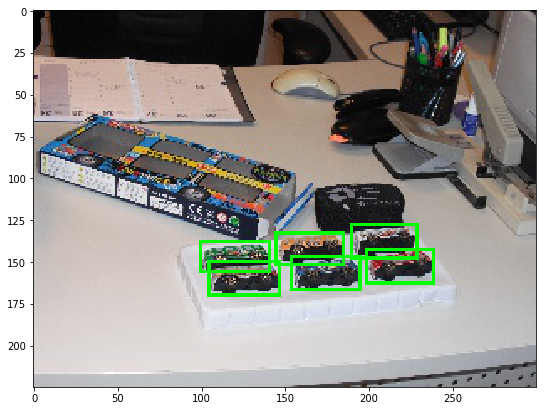

In [9]:
imshow_bbox(images, bboxes, 1)

In [10]:
sometimes = lambda aug: iaa.Sometimes(0.8, aug)
def seq_det_aug():
    seq = iaa.Sequential([iaa.Multiply(mul=(0.75, 1.25)),
                    iaa.Add(value=(-25,25)),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.OneOf([
                    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
                    iaa.AdditiveGaussianNoise(scale=(0, 0.02*255))]),
                    sometimes(iaa.Affine(
                            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                            rotate=(-45, 45), # rotate by -45 to +45 degrees
                            shear=(-16, 16), # shear by -16 to +16 degrees
                            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                            cval=0, # if mode is constant, use cval 0
                        ))])
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    return seq_det

                filename  width  height class  xmin  ymin  xmax  ymax     path
0   aug_0_s_DSCF1013.JPG    300     300   bus   159   175   199   192  images/
1   aug_0_s_DSCF1013.JPG    300     300   bus   115   170   154   188  images/
2   aug_0_s_DSCF1013.JPG    300     300   bus    71   165   109   184  images/
3   aug_0_s_DSCF1013.JPG    300     300   bus   153   187   194   206  images/
4   aug_0_s_DSCF1013.JPG    300     300   bus   105   184   145   203  images/
5   aug_0_s_DSCF1013.JPG    300     300   bus    61   180   100   199  images/
6   aug_0_s_DSCF1015.JPG    300     300   bus    98   142   193   245  images/
7   aug_0_s_DSCF1015.JPG    300     300   bus     4   175    93   262  images/
8   aug_0_s_DSCF1016.JPG    300     300   bus   128   133   235   223  images/
9   aug_0_s_DSCF1016.JPG    300     300   bus   141    61   239   144  images/
10  aug_0_s_DSCF1016.JPG    300     300   bus   127    37   227    95  images/
11  aug_0_s_DSCF1017.JPG    300     300   bus    92 

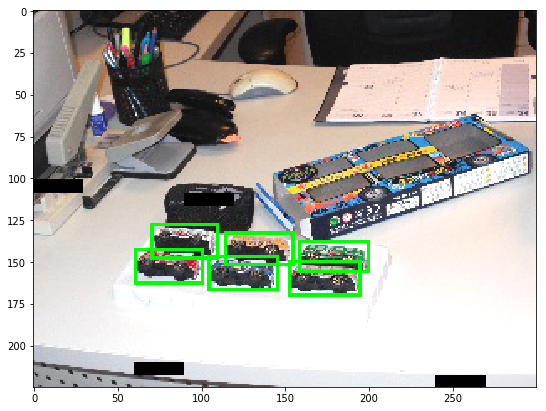

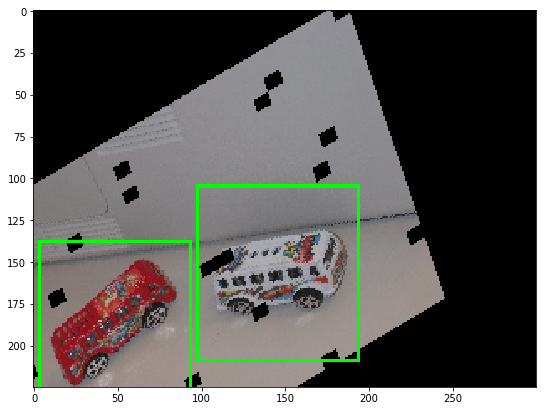

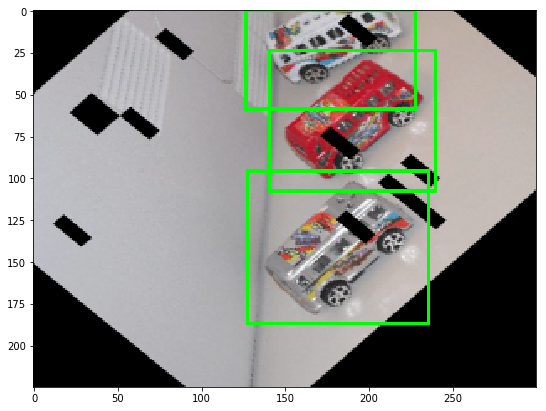

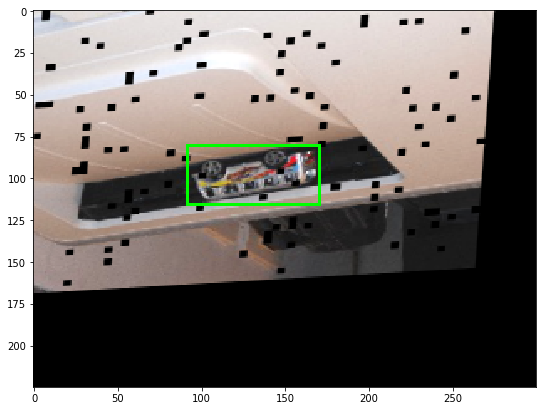

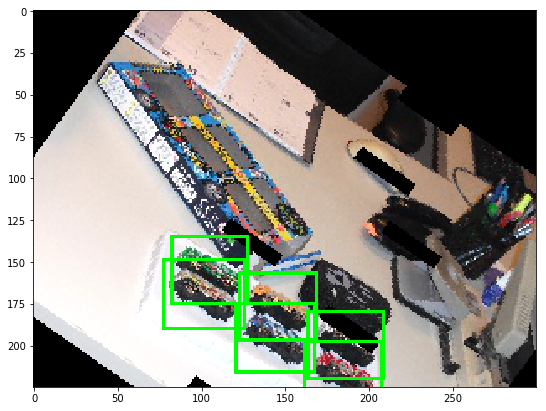

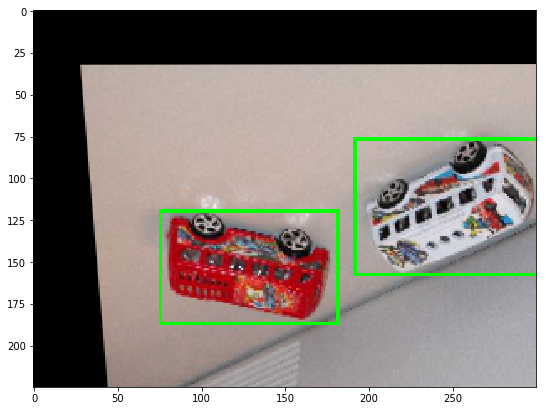

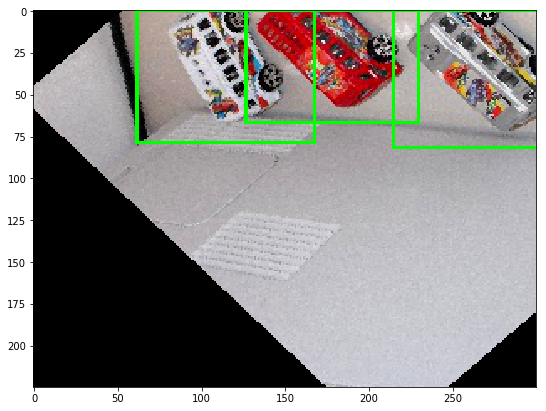

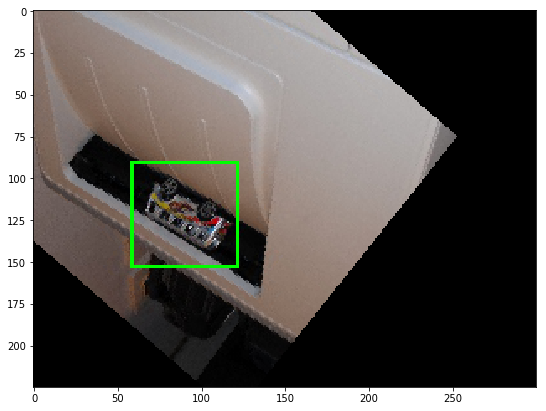

In [11]:
batch = 2
for i in range(batch):
    seq = seq_det_aug()
    images_aug = seq.augment_images(images)
    bboxes_aug = seq.augment_bounding_boxes(bboxes)
    filename_aug_batch = [str(i) + '_' + f for f in filenames_s]
    df_batch = imwrite_aug_ssd(images_aug, filename_aug_batch, bboxes_aug, PATH_TO_AUG_IMAGES, None)
    print(df_batch.head(18))
    imshow_bbox(images_aug, bboxes_aug, 4)

In [ ]:
[filenames_s, images, bboxes] = get_images_bboxes(df=df_batch, path_to_images=PATH_TO_AUG_IMAGES)